## Objectives: 

Step 1 of the wildfire-lake-productivity project

    1. Import deepest point for each lake in the HydroLAKES dataset 
        a. crop dataset to area of interest
        b. generate a 2km buffer around each deep point (proxy for lake catchment)
    2. Import lake polygons from HydroLAKES dataset
        a. crop dataset to area of interest   
    3. Import MTBS data
        a. crop dataset to area of interest
        b. save polygons from HydroLakes buffer region (with lake) that overlap with MTBS dataframe to a geopandas df
            i. 'intersect' will produce a dataframe with just the overlapping areas among polygons. 
          ii. save whole MTBS fire polygons as second shapefile for later analysis
         iii. save whole burned lake perimeters as a third shapefile
        c. save polygons from HydroLakes buffer region (without lake) that overlap with MTBS dataframe to a geopandas df
            i. calculate area of catchment without lake (land area)
           ii. calculate area of catchment without lake that has been burned    
    4. Import LimnoSat data from R generated .csv 
        a. subset LimnoSat data with 'Hylak_id' from burned lake perimeters

Run with wildfire-lake-productivity environment

# 1.  Import packages

In [1]:
import os
import os.path as op
import io

import earthpy as et
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
from functools import partial
import pyproj
import pyarrow
from shapely.geometry import Point # for making buffers around each point
from shapely.ops import transform
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
import folium

import ee
import geemap

import datatools

# Am I still using these?
#from functools import reduce #spatial overlay function
#from datetime import datetime

# Initialize Google Earth Engine to generate area of interest and deep_point data
# Will need internet connection for this 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

#import warnings
#warnings.filterwarnings("ignore")

# 2. Make/set working directory

In [2]:
# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'cu_earthdata_certificate_2021', 'earthlab_project', 'data')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
    print("path exists")
else:
    print("path does not exist, making new path")
    os.makedirs(data_dir)
    os.chdir(data_dir)

path exists


# 3. Download and buffer lake data

### 3a. Download the area of interest shapefile
Download one file includes states of interest from Earth Engine's TIGER 2018 census dataset to use in clipping the HydroLAKES (use FeatureCollection) and MTBS (use geopandas dataframe) datasets.  

In [3]:
lis = ['Colorado','Utah', 'Wyoming', 'New Mexico', 'Arizona']
states = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.inList('NAME', lis))

states_gdf = geemap.ee_to_geopandas(states, selectors = ['NAME'])
print("The crs of your area of interest df is", states_gdf.crs)
states_gdf.head()

bounding_box = states_gdf.envelope
states_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
states_bb

An error occurred while downloading. 
 Retrying ...
Generating URL ...
Please wait ...
The crs of your area of interest df is epsg:4326


,geometry
0,"POLYGON ((-109.05041 31.33222, -103.00203 31.3..."
1,"POLYGON ((-114.05288 36.99765, -109.04157 36.9..."
2,"POLYGON ((-109.06020 36.99245, -102.04153 36.9..."
3,"POLYGON ((-111.05454 40.99478, -104.05226 40.9..."
4,"POLYGON ((-114.81657 31.33217, -109.04516 31.3..."


## 3b. Download lake .shps from HydroLAKES
Each entry of the HydroLAKES dataset can be matched to the LimnoSat dataset which provides lake median values for selected Landsat bands for all of the CONUS, via the Hylak_id column. HydroLAKES is the source of lake name and data, including lat-long values for each lake "deep point" as described by Topp et al. 2020. This dataset can be clipped to a Colorado shapefile, and then matched to LimnoSat so that only values that match both dataframes are saved. The GEE script in the link below also contains the lake pour points.

In [4]:
# Download HydroLAKES point data for area of interest
# HydroLAKES deepest points (used for LIMNOsat data) is a Google Earth Engine asset.

dp = ee.FeatureCollection('users/eeProject/HydroLAKES_newct_NA_e5e5da51107417d472452564cef3eb4f').filterMetadata(
    'type', 'equals', 'dp').filterMetadata('distance', "greater_than", 60).filterBounds(states)
hydro_points = geemap.ee_to_geopandas(dp, selectors=['Hylak_id'])
hydro_points.head()

# change to projected .crs for buffer calculation
hydro_points = hydro_points.to_crs(epsg=26953)

In [5]:
# Checking the data format
hydro_points.head() # make sure that Hylak_id is an integer
#print("Projection of dataframe: {}".format(hydro_points.crs))

,Hylak_id,geometry
0,1041819,POINT (1015847.647 928309.139)
1,1046301,POINT (996570.899 841083.446)
2,1046134,POINT (817227.430 845842.761)
3,1045207,POINT (778185.333 870036.765)
4,1041752,POINT (595944.526 935296.808)


In [6]:
hydro_color = hydro_points.copy()
# Generate buffer
hydro_color['geometry']=hydro_color.geometry.buffer(120)
hydro_color = hydro_color.to_crs(states_gdf.crs)

## 3c.  Generate a 2km buffer around each deep point. 
This will be a proxy for the lake "catchment"

In [7]:
# Generate buffer
hydro_points['geometry']=hydro_points.geometry.buffer(2000)

Projection of dataframe: epsg:4326


<AxesSubplot:>

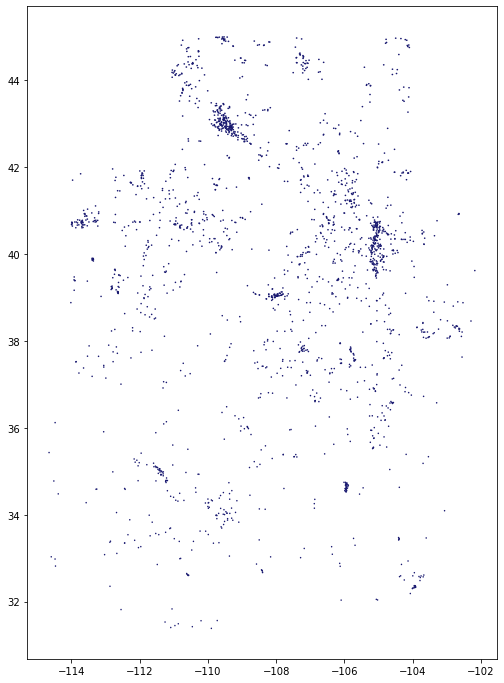

In [8]:
# make sure crs aligns with area of interest

hydro_points = hydro_points.to_crs(states_gdf.crs)
print("Projection of dataframe: {}".format(hydro_points.crs))

# Plot points
fig, ax = plt.subplots(figsize=(16, 12))

hydro_points['geometry'].plot(ax=ax,
                              color='midnightblue')

# 3d.  Download lake polys.  
Once we identify which lakes are fire affected, we'll remove these from hydro_points so that remaining polygons are of land.  These will be the polygons over which we collect landscape data like vegetation indices. 

In [9]:
# Download HydroLAKES polygon data and clip to area of interest

# 'open _zips' will join 'data' folder, so change working directory
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'cu_earthdata_certificate_2021', 'earthlab_project')
os.chdir(data_dir)

file_path = os.path.join(
    'data', "HydroLAKES_polys_v10_shp", "HydroLAKES_polys_v10.shp")

if not os.path.isfile(file_path):
    url = 'https://97dc600d3ccc765f840c-d5a4231de41cd7a15e06ac00b0bcc552.ssl.cf5.rackcdn.com/HydroLAKES_polys_v10_shp.zip'
    hydro_polys = datatools.open_zips(url, states_bb)
    hydro_polys.to_file(file_path)

else:
    hydro_polys = gpd.read_file(file_path)

In [10]:
hydro_polys.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Hylak_id   2039 non-null   int64   
 1   Lake_name  133 non-null    object  
 2   Country    2039 non-null   object  
 3   Continent  2039 non-null   object  
 4   Poly_src   2039 non-null   object  
 5   Lake_type  2039 non-null   int64   
 6   Grand_id   2039 non-null   int64   
 7   Lake_area  2039 non-null   float64 
 8   Shore_len  2039 non-null   float64 
 9   Shore_dev  2039 non-null   float64 
 10  Vol_total  2039 non-null   float64 
 11  Vol_res    2039 non-null   float64 
 12  Vol_src    2039 non-null   int64   
 13  Depth_avg  2039 non-null   float64 
 14  Dis_avg    2039 non-null   float64 
 15  Res_time   2039 non-null   float64 
 16  Elevation  2039 non-null   int64   
 17  Slope_100  2039 non-null   float64 
 18  Wshd_area  2039 non-null   float64 
 19  Pour_long  2039 non

# 4. Download and merge fire data with lake dataset
Subsetting the lake dataset based on overlap with MTBS polygons

### 4a. Download MTBS fire polygons within the area of interest

In [11]:
# Check to see if file is stored locally

file_path = os.path.join('data', "mtbs_polys.shp")

if not os.path.isfile(file_path):
    url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/composite_data/burned_area_extent_shapefile/mtbs_perimeter_data.zip'
    mtbs_polys = datatools.open_zips(url, states_bb)
    mtbs_polys.to_file(file_path)

else:
    mtbs_polys = gpd.read_file(file_path)

Projection of dataframe: epsg:4326


<AxesSubplot:>

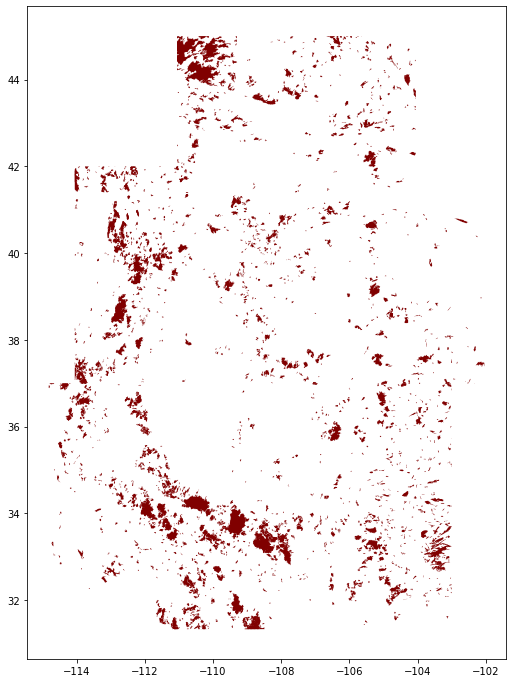

In [12]:
# Observe data
mtbs_polys.head()
mtbs_polys = mtbs_polys.to_crs(states_gdf.crs)
print("Projection of dataframe: {}".format(mtbs_polys.crs))

# Plot points
fig, ax = plt.subplots(figsize=(16, 12))

mtbs_polys['geometry'].plot(ax=ax,
                            color='maroon')

## 4b. Merge (full) buffered lake dataset and MTBS fire dataset
Find burned lakes by merging 2km lake and fire datasets and identify overlaps with new set of polygons.
'full' buffered lakes refer to 2km buffers without lake/water polygons removed.  This dataset
will be used mostly for visualization and matching with AquaSat data since AquaSat points are likely 
within lake/water polygons. 

In [13]:
# Merge fire and lake datasets
burnedlakes = gpd.overlay(hydro_points, mtbs_polys,
                          how='intersection', keep_geom_type=False)

In [14]:
# Geometries in this file are ONLY the burned portion of each catchment.
# Use to calculate portion of whole catchment burned
out_path = os.path.join('data', "burnpolys.shp")
burnedlakes.to_file(out_path)

[None]

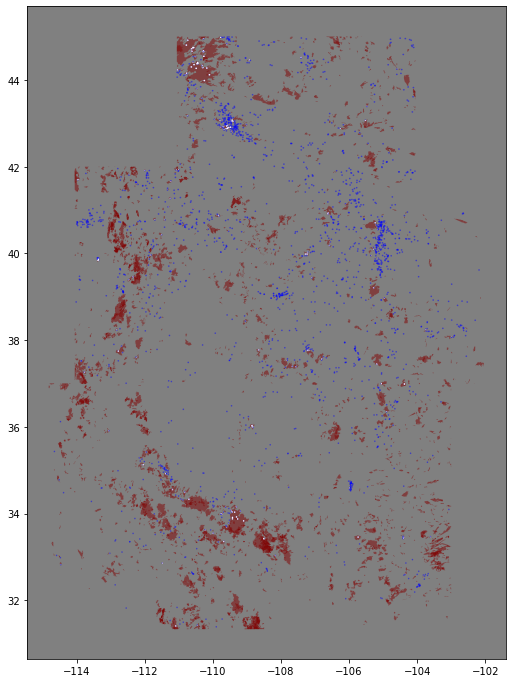

In [15]:
fig, ax = plt.subplots(figsize=(16, 12))

mtbs_polys['geometry'].plot(ax=ax,
                            color='maroon',
                            alpha=0.5)

hydro_points['geometry'].plot(ax=ax,
                              color='blue',
                              alpha=0.5)

burnedlakes['geometry'].plot(ax=ax, color='white')

ax.set(facecolor="grey")
# .set_axis_off()

## 4c. Export shapefiles

In [16]:
# To keep full burn perimeter for later classification, subset full MTBS
# dataset to include only fires that affected lakes in the merged datframe

subset_mtbs = mtbs_polys[mtbs_polys.set_index(['Event_ID']).index.isin(
    burnedlakes.set_index(['Event_ID']).index)]  # subset mtbs to fire ID found in burnedlakes

outfp = os.path.join('data', "fire_perimeters.shp")
subset_mtbs.to_file(outfp)

# To keep full lake polygon for later classification, subset hydroLAKES deep points
# dataset to include only fire affected lakes

subset_catchmnts = hydro_points[hydro_points.set_index(['Hylak_id']).index.isin(
    burnedlakes.set_index(['Hylak_id']).index)]  # subset hydro points to lake name found in burnedlakes
outfp = os.path.join('data', "whole_burned_lakes.shp")
subset_catchmnts.to_file(outfp)

## 4d. Generate study area figures 

In [17]:
images_dir_path = op.join(
    'ea-2021-final-project-wildfire_lake_productivity', 'images')
# op.abspath('')
# op.dirname(),
# Check that is exists, and if it doesn't, create it
if not op.isdir(images_dir_path):
    os.mkdir(images_dir_path)

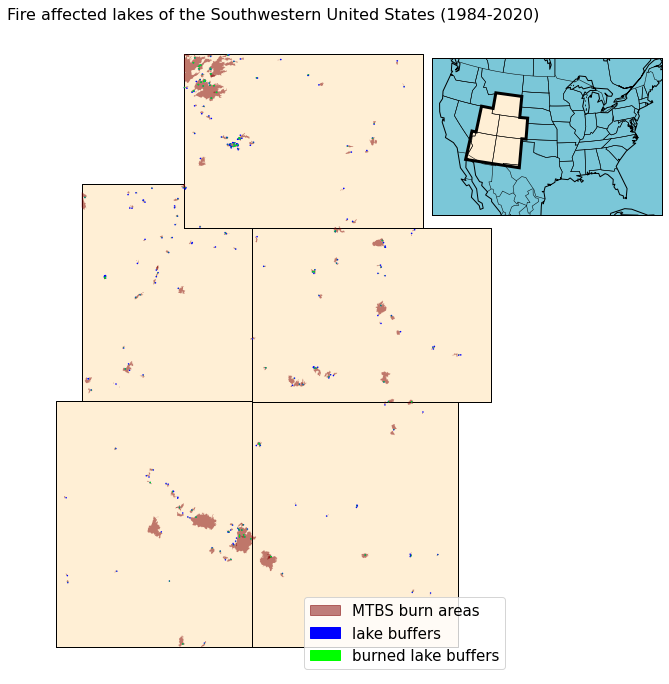

In [18]:
# Set asthetics for main (polys) map
fig, ax1 = plt.subplots(figsize=(16, 12))
plt.title(
    "Fire affected lakes of the Southwestern United States (1984-2020)", fontsize=16)
plt.axis('off')  # command for hiding the axis.
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')

# Add a legend for polygons
red_patch = mpatches.Patch(color='maroon', alpha=0.5, label='MTBS burn areas')
blue_patch = mpatches.Patch(color='blue', label='lake buffers')
green_patch = mpatches.Patch(color='lime', label='burned lake buffers')

plt.legend(handles=[red_patch, blue_patch, green_patch],
           loc='lower right', fontsize=15)

# These are in unitless percentages of the inset figure size. (0,0 is bottom left)
left, bottom, width, height = [0.65, 0.65, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

# Plot burned lakes in area of interest
states_bb.plot(ax=ax1,
               color='papayawhip', edgecolors='black')
subset_mtbs['geometry'].plot(ax=ax1,
                             color='maroon',
                             alpha=0.5)
subset_catchmnts['geometry'].plot(ax=ax1,
                              color='blue')
burnedlakes['geometry'].plot(ax=ax1, color='lime')

# Add the USA inset map
ax2 = Basemap(llcrnrlon=-119, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
              projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
ax2.drawmapboundary(fill_color='#7BC7D8')
ax2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
ax2.drawstates()
ax2.drawcoastlines()
ax2.drawcountries()

# Add area of interest polygon to inset map
x1, y1 = ax2(-111, 45)  # nw corner of WY
x2, y2 = ax2(-111, 42)  # int UT and WY
x3, y3 = ax2(-114, 42)  # nw corner of UT
x4, y4 = ax2(-114, 37)  # sw corner of UT
x5, y5 = ax2(-115, 37)  # nw corner of AZbb
x6, y6 = ax2(-115, 31.5)  # sw corner of AZbb
x7, y7 = ax2(-103, 31.5)  # se corner of NMbb
x8, y8 = ax2(-103, 37)  # ne corner of NMbb
x9, y9 = ax2(-102, 37)  # se corner of CObb
x10, y10 = ax2(-102, 41)  # ne corner of CObb
x11, y11 = ax2(-104, 41)  # se corner of WY
x12, y12 = ax2(-104, 45)  # ne corner of WY
x13, y13 = ax2(-111, 45)  # nw corner of WY

poly = Polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), (x6, y6), (x7, y7), (x8, y8),
               (x9, y9), (x10, y10), (x11, y11), (x12, y12), (x13, y13)], facecolor='papayawhip', edgecolor='black', linewidth=3)
plt.gca().add_patch(poly)

plt.show()

In [19]:
# Save the image to the images directory for use in blog
fig.savefig(op.join(images_dir_path, 'burn_polys.png'),
           bbox_inches='tight', dpi=150)

# 4e. Generate land-only lake buffer polygons
The df 'subset_lakes' are polygons of the 2km buffer around each lake that include the lake.
In this next section we want to:
    a. generate a set of polygons where the lake is 'removed' from the 2km buffer
    b. match these polygons to the 'burnedlakes' dataset to determine the area and percentage of the 2km buffer area that was burned. 

In [20]:
# Subset lake polygons to burned lakes only
subset_lakes = hydro_polys[hydro_polys.set_index(['Hylak_id']).index.isin(
    burnedlakes.set_index(['Hylak_id']).index)]  # subset hydro points to lake name found in burnedlakes

# Generate catchment 'land' polygons by subtracting lake polygons from buffered point polygons
only_land = gpd.overlay(subset_catchmnts, subset_lakes,
                        how='difference', keep_geom_type=False)

# Export for further data collection
outfp = os.path.join('data', "land_only_whole_ctchmt.shp")
only_land.to_file(outfp)

In [21]:
only_land.head()

,Hylak_id,geometry
5,1041368,"POLYGON ((-109.74106 44.98857, -109.74106 44.9..."
6,1043550,"POLYGON ((-110.59727 44.72229, -110.59725 44.7..."
19,1061701,"POLYGON ((-110.91748 34.33585, -110.91746 34.3..."
20,1061706,"POLYGON ((-110.67876 34.33166, -110.67874 34.3..."
22,1059986,"POLYGON ((-108.90854 35.98128, -108.90856 35.9..."


In [22]:
# Stamen Terrain
map = folium.Map(location=[37, -105], tiles="Stamen Terrain", zoom_start=5)

for _, f in subset_lakes.iterrows():
    sim_geo = gpd.GeoSeries(f['geometry']).simplify(tolerance=0.001)
    geo_f = sim_geo.to_json()
    geo_f = folium.GeoJson(data=geo_f,
                           style_function=lambda x: {'fillColor': 'blue', 'color': 'blue'})
    # geo_f.add_child(folium.Popup(f['Hylak_id']))
    # folium.Popup(r['Incid_Name']).add_to(geo_j)
    geo_f.add_to(map)


for _, f in subset_mtbs.iterrows():
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(f['geometry']).simplify(tolerance=0.001)
    geo_f = sim_geo.to_json()
    geo_f = folium.GeoJson(data=geo_f,
                           style_function=lambda x: {'fillColor': 'red', 'color': 'red'})
    geo_f.add_child(folium.Popup(f['Incid_Name']))
    # folium.Popup(r['Incid_Name']).add_to(geo_j)
    geo_f.add_to(map)

for _, f in only_land.iterrows():
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(f['geometry']).simplify(tolerance=0.001)
    geo_f = sim_geo.to_json()
    geo_f = folium.GeoJson(data=geo_f,
                           style_function=lambda x: {'fillColor': 'white', 'color': 'white'})
    # geo_f.add_child(folium.Popup(f['Incid_Name']))
    # folium.Popup(r['Incid_Name']).add_to(geo_j)
    geo_f.add_to(map)

map

# 4f. Calculate burned area for each polygon and export as dataframe

In [23]:
#1. Calculate area of whole polygon (minus lake)
only_land = only_land.to_crs({'init': 'epsg:32633'})
only_land["wholearea"] = only_land['geometry'].area/ 10**6

#2. Calculate area of whole burn polygon
burnedlakes = burnedlakes.to_crs({'init': 'epsg:32633'})
burnedlakes["burnedarea"] = burnedlakes['geometry'].area/ 10**6

# 3. Bind burned area column to only_land dataframe
small_burnedlakes = burnedlakes[['Hylak_id', 'burnedarea']]

only_land = pd.merge(only_land, small_burnedlakes)

#3. Calculate percentage of whole polygon burned
only_land["percentburned"] = only_land["burnedarea"]/only_land["wholearea"]*100

# Export as .csv
only_land_tab = only_land.drop(['geometry'], axis=1)


# Export file to local drive
out_path = os.path.join("data", "polygon_areas_tab.csv")
only_land_tab.to_csv(out_path)

In [24]:
only_land

,Hylak_id,geometry,wholearea,burnedarea,percentburned
0,1041368,"POLYGON ((-3741725.175 13304979.917, -3741896....",18.521021,11.715746,63.256480
1,1043550,"POLYGON ((-3708807.693 13389383.961, -3708977....",18.390611,16.826233,91.493608
2,1061701,"POLYGON ((-4660261.995 14521640.876, -4660426....",22.125529,1.592121,7.195853
3,1061706,"POLYGON ((-4683919.077 14503864.952, -4684084....",22.369237,21.793472,97.426087
4,1059986,"POLYGON ((-4693324.371 14174936.493, -4693496....",22.478108,0.119100,0.529851
...,...,...,...,...,...
358,1042213,"POLYGON ((-3856740.948 13205408.924, -3856916....",18.655479,0.000254,0.001363
359,1048160,"POLYGON ((-3839209.205 13480231.735, -3839379....",18.282383,2.515622,13.759813
360,1062887,"POLYGON ((-4861485.543 14552957.098, -4861651....",21.556986,1.303346,6.046051
361,112308,"POLYGON ((-4061503.141 14063097.615, -4061667....",16.145674,9.473056,58.672407


### Checking in:
Now there should be at least 3 local shapefiles for later use:

    1. a shapefile containing whole burn perimeters - fire_perimeters.shp. These won't be used for summer 2021 course, but would be used to caluclate area of severity classifications and percent of each severity type of burned area. 
    2. a shapefile containing full lake polygons (burned only) - whole_burned_lakes.shp
    3. a shapefile containing polygons that represent only the land - land_burned_lakes.shp  - used for collection of topography, landcover and vegetation index data
        in a 2km buffer around the burned lakes with area calculations

And a .csv with polygon areas

# 6. Adding Landsat lake color data
LimnoSAT a remote sensing dataset for inland waters from cloud-free Landsat observations of U.S. lakes larger than 0.1 km^2.  Reflectance values are extracted from the Chebyshev Center: the  center of the largest circle that can fit entirely within a given polygon's boundary(Topp et al. 2020, Shen et al. 2015) Topp et al. identify this point as the location of the pixel that is furthest away from the lake shoreline (derived from GEE script by Topp et al.) 

In [25]:
# Download LimnoSAT image data
# Check if file already exists before downloading it:

file_path = os.path.join('data', "limnosat_pnts.feather")

if not os.path.isfile(file_path):    
    resp = requests.get(
        "https://zenodo.org/record/4139695/files/srCorrected_us_hydrolakes_dp_20200628.feather",
        stream=True)

    resp.raw.decode_content = True
    limn_fthr = io.BytesIO(resp.raw.read())
    limnosat = pd.read_feather(limn_fthr)    
    # Write out for future use if desired
    limnosat.to_feather(file_path)
    
else:
    limnosat = pd.read_feather(file_path)

If .csv is preferred, replace last lines with:
    
   limnosat.to_csv(file_path)
    
else:
    limnosat = pd.read_csv(file_path)

In [26]:
limnosat['Hylak_id'] = limnosat['Hylak_id'].astype(int)
limnosat = limnosat.set_index(['Hylak_id'])
limnosat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22301620 entries, 1028663 to 8499
Data columns (total 16 columns):
 #   Column        Dtype   
---  ------        -----   
 0   LandsatID     object  
 1   date          object  
 2   Aerosol       float64 
 3   Blue          float64 
 4   Red           float64 
 5   Green         float64 
 6   Nir           float64 
 7   Swir1         float64 
 8   Swir2         float64 
 9   TIR1          float64 
 10  TIR2          float64 
 11  sat           category
 12  pCount_dswe1  float64 
 13  pCount_dswe3  float64 
 14  year          int32   
 15  dWL           float64 
dtypes: category(1), float64(12), int32(1), object(2)
memory usage: 2.6+ GB


In [27]:
limnosat['date'] = pd.to_datetime(limnosat['date'])
#limnosat = limnosat.drop(['geometry', 'Country', 'Continent'], axis=1)

## 5a. Subset LimnoSat dataset 
LimnoSat CONUS to LimnoSat Colorado data by matching rows from Colorado 
deep lakes (hydro_points) to whole LimnoSat dataset, then merge the dataframes to generate
a LimnoSat dataset with burned lake deep points.

In [28]:
# Conversion of shared column to integer and index before merging (makes merge faster)
burnedlakes= burnedlakes.set_index(['Hylak_id'])

# Shorten limnosat to only lakes desired, makes merge faster
subset_limno = limnosat[limnosat.index.isin(
    burnedlakes.index)]  # subset LimnoSat to lake IDs found in CO HydroLAKES points

In [29]:
# Merge on shared variable (Hylak_id):
limnosat_pnts = subset_limno.merge(burnedlakes, on='Hylak_id')

In [30]:
# Export tabular data as .csv for faster use in data observations (ie. 02_observe_color_trends)
limnosat_pnts1 = limnosat_pnts.copy()
limnosat_pnts1 = limnosat_pnts1.drop(['geometry', 'geometry', 'Comment'], axis=1)

# Change category datatypes 
limnosat_pnts1['sat'] = limnosat_pnts1['sat'].astype(str)

# Export file to local drive
out_path = os.path.join("data", "lake_mtbs_merged_tab.csv")
limnosat_pnts1.to_csv(out_path)

In [31]:
# Export same data with geometry 
# Change category datatypes 
limnosat_pnts['sat'] = limnosat_pnts['sat'].astype(str)
limnosat_pnts['date'] = 'datetime'

# Change from dataframe to geodataframe by establishing geometry
limnosat_pnts = gpd.GeoDataFrame(limnosat_pnts, crs="EPSG:4326")
limnosat_pnts = limnosat_pnts.set_geometry("geometry")

# Export file to local drive
out_path = os.path.join('data', "landsat_n_burnpolys.shp")
limnosat_pnts.to_file(out_path)


This is the fourth local shapefile containing partial lake polygons (portions that overlap with fire) along
with Landsat band values from LimnoSAT dataset - landsat_n_burnpolys.shp